In [2]:
# Graphs current IV in notebook.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
import json
from pandas.io.json import json_normalize
import os

...scraping ^SPX (1/3)


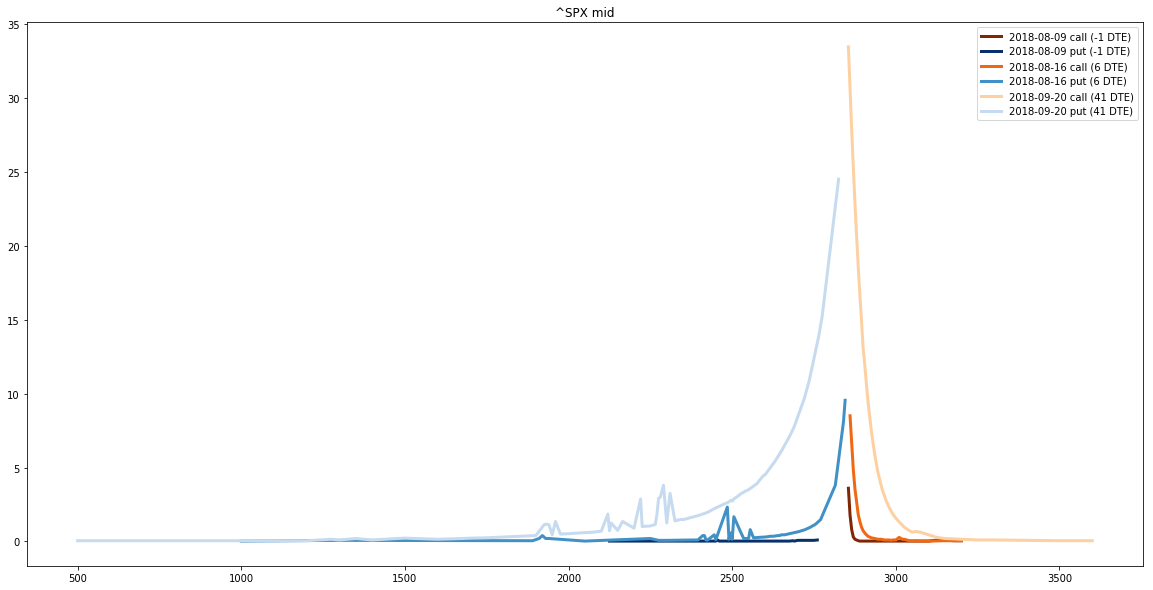

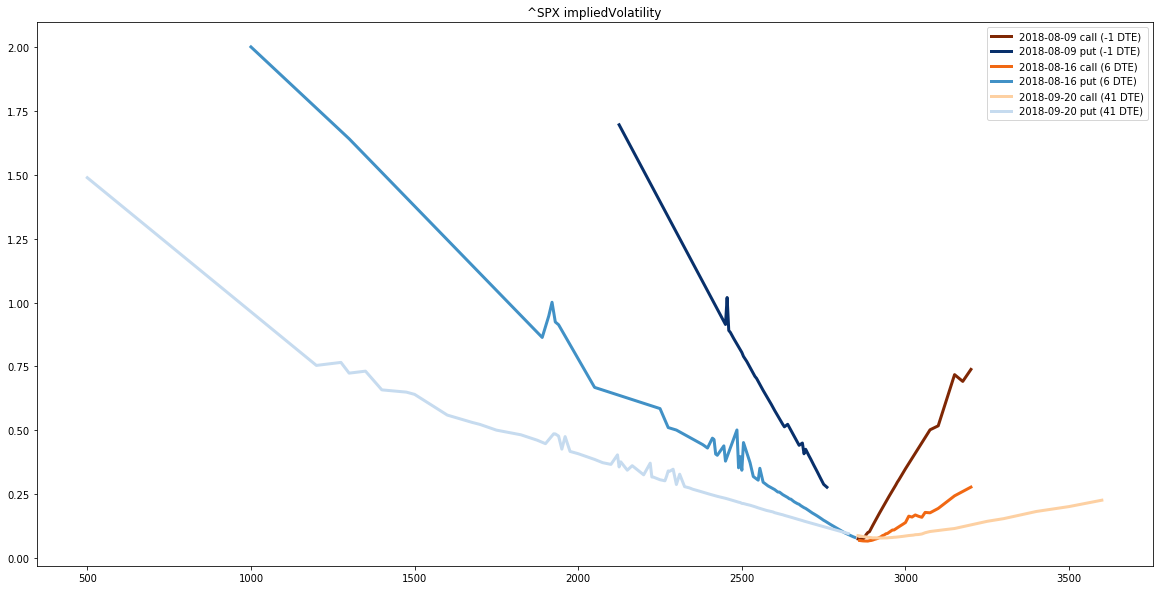

...scraping TSLA (2/3)


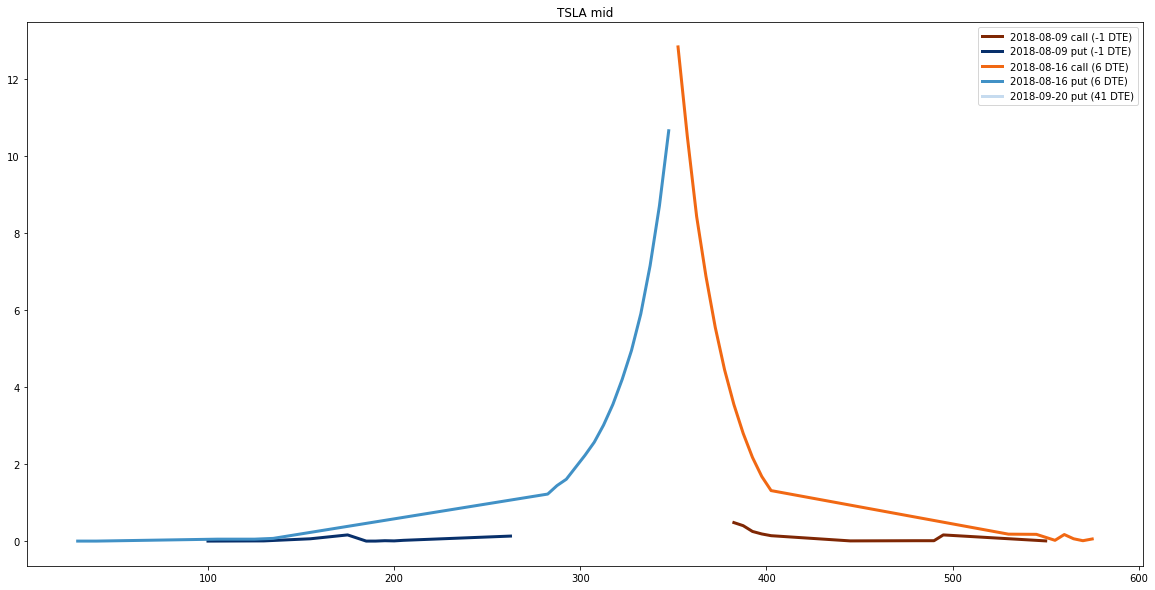

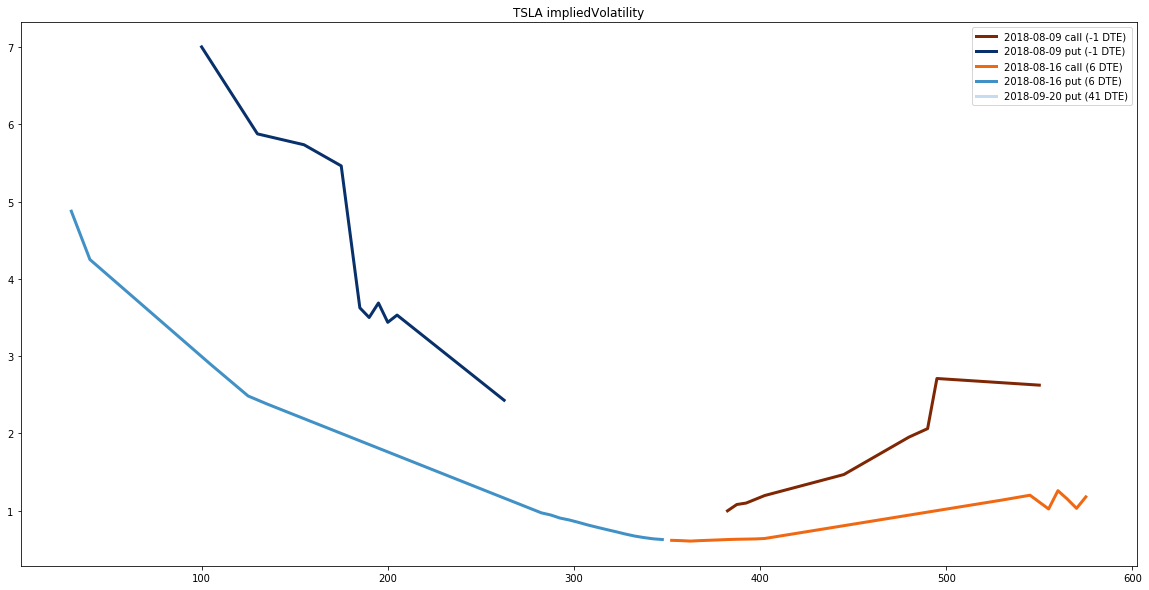

...scraping IQ (3/3)


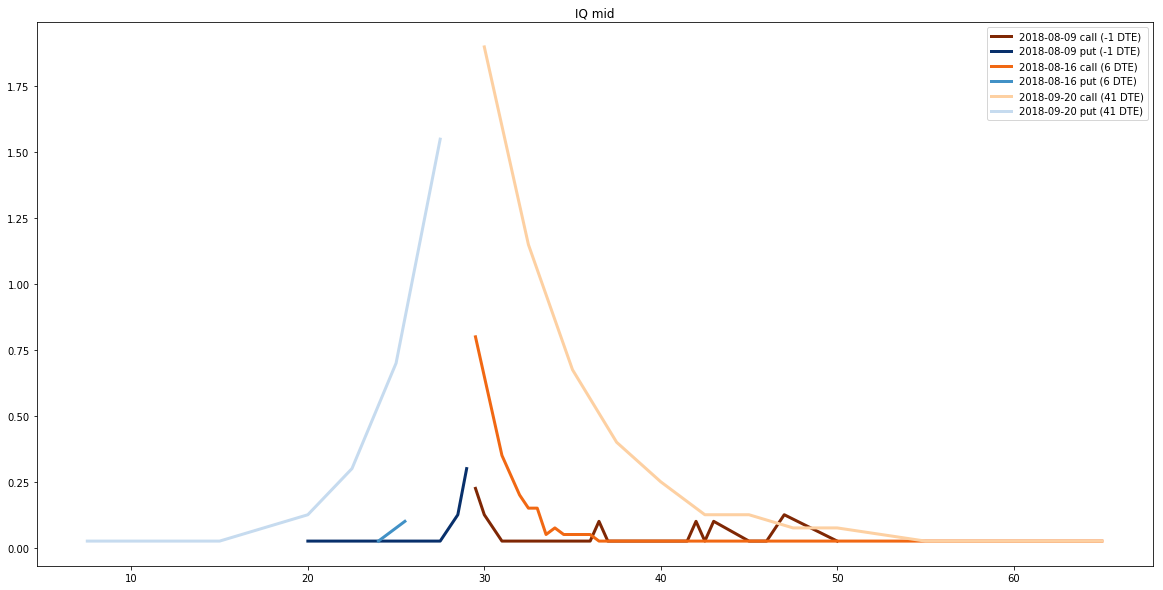

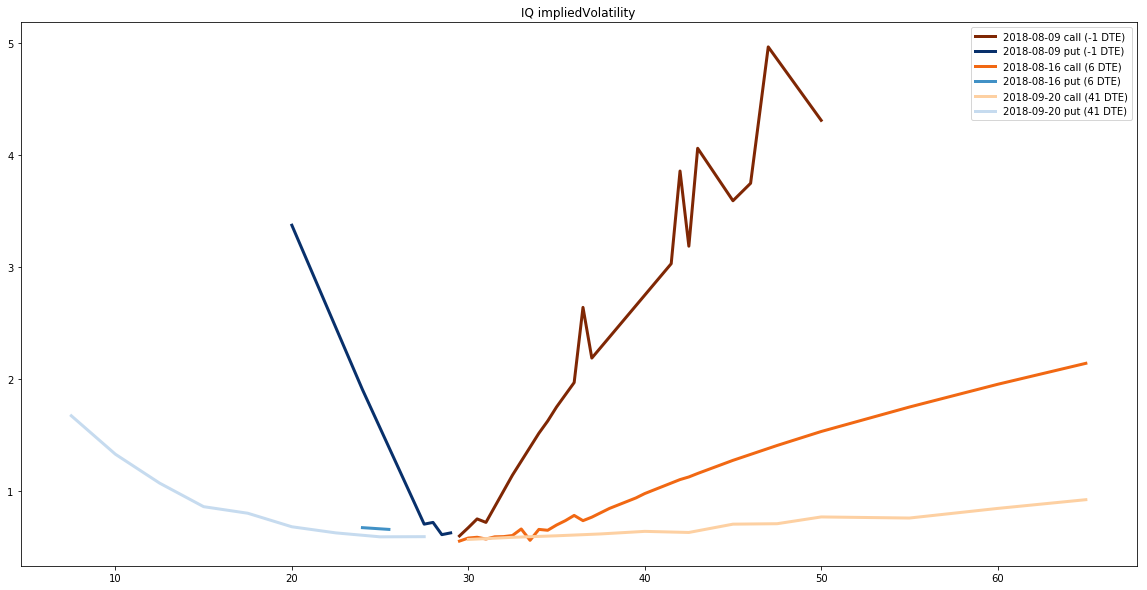

In [15]:
symbol_list = ['^SPX', 'TSLA', 'IQ']

url = 'https://query2.finance.yahoo.com/v7/finance/options/'

timestamp = datetime.datetime.now().strftime('%Y%m%d')

# Gets the third friday exp

def is_third_friday(s):
    d = datetime.datetime.strptime(s, '%Y-%m-%d')
    return d.weekday() == 3 and 15 <= d.day <= 21

# Gets expiration dates (in unix), converts to human time, gets the first weekly and two monthly dates, gets unix/human time for those.

def date_lister(symbol, exp):

    global dates_list

    # Make df for unix and human exp dates

    exp_df = pd.DataFrame()
    exp_df['unix'] = exp[0].values

    # Get human values for exp_df

    ht_list = []

    for i in exp[0]:

        ht = datetime.datetime.fromtimestamp(int(i)).strftime('%Y-%m-%d')
        ht_list.append(ht)

    exp_df['human'] = ht_list

    # Get nonweekly dates

    non_weeklies = []

    for date in ht_list:
        if is_third_friday(date) == True:
            non_weeklies.append(date)

        else:
            pass

    # Make list with first weekly and two nonweeklies

    dates_list = []
    dates_list.append(ht_list[0])

    for i in non_weeklies[:2]:
        dates_list.append(i)

    dates_list = pd.DataFrame(data = dates_list, columns = ['human'])
    dates_list['unix'] = [(exp_df.loc[exp_df['human'] == i, 'unix'].values[0]) for i in dates_list['human']]
    
    #print(dates_list)

def scraper(symbol):

    print('...scraping ' + symbol + ' (' + str(symbol_list.index(symbol) + 1) + '/' + str(len(symbol_list)) + ')')

    global oc_df

    optionschain = []

    for date in dates_list['unix']:

        newurl2 = newurl + '?date=' + str(date)

        # Temporary df's for our shit, written to different df later for output

        temp_df = pd.read_json(newurl2)

        chain = json_normalize(data=temp_df['optionChain']['result'], record_path='options')

        for j in chain.calls[0]:

            j.update({'type': 'call'})
            optionschain.append(j)

        for k in chain.puts[0]:

            k.update({'type': 'put'})
            optionschain.append(k)

        oc_df = pd.DataFrame(optionschain)

    ### Add mid, add DTE, add mid ###

    for i in range(len(oc_df)):
        oc_df.loc[i, 'human'] = datetime.datetime.fromtimestamp(int(oc_df.loc[i, 'expiration'])).strftime('%Y-%m-%d')
        oc_df.loc[i, 'dte'] = (datetime.datetime.strptime(oc_df.loc[i, 'human'], '%Y-%m-%d') - datetime.datetime.now()).days

    oc_df['mid'] = (oc_df['ask'] + oc_df['bid']) / 2
    
def graph(symbol):

    for j in ['mid', 'impliedVolatility']:

        plt.figure(figsize = (20,10))

        colors = np.linspace(1, .25, len(dates_list))

        for i, k in zip(dates_list['human'], colors):

            iv = oc_df[oc_df['human'] == i]

            iv_put = iv[iv['type'] == 'put']
            iv_call = iv[iv['type'] == 'call']

            otm_put = iv_put[iv_put['inTheMoney'] == False]
            otm_call = iv_call[iv_call['inTheMoney'] == False]

            try:
                plt.plot(otm_call[['strike', j]].set_index('strike'), label = str(i) + ' call ' + '(' + str(int(otm_put.loc[otm_put['human'] == i, 'dte'].values[0])) + ' DTE)', color=plt.cm.Oranges(k), lw=3)
            except:
                pass
            
            try:
                plt.plot(otm_put[['strike', j]].set_index('strike'), label = str(i) + ' put ' + '(' + str(int(otm_call.loc[otm_call['human'] == i, 'dte'].values[0])) + ' DTE)', color=plt.cm.Blues(k), lw=3)
            except:
                pass
            
        plt.title(symbol + ' ' + j)
        plt.legend()
        plt.show()

def chart_maker(symbol):

    global newurl
    
    newurl = url + symbol

    df = pd.read_json(newurl)

    exp = json_normalize(data = df['optionChain']['result'], record_path = 'expirationDates')

    date_lister(symbol, exp)
    scraper(symbol)
    graph(symbol)

def actual_chart_maker_loop(symbol_list):

    for symbol in symbol_list:
        chart_maker(symbol)

actual_chart_maker_loop(symbol_list)
